# Shared Task
## Preparations

In [16]:
import pandas as pd
import spacy
import os
import csv
import nltk

import matplotlib.pyplot as plt

nltk.download('wordnet')
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from nltk.corpus import wordnet as wn
from tqdm import tqdm_notebook as tqdm
from pprint import pprint
from spacy import displacy
from enum import Enum
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score, GridSearchCV


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\syim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
nlp = spacy.load('en_core_web_lg')
pd.set_option('display.max_colwidth',-1)

**LOAD DATA**

In [33]:
folder = '../Documents/ELEXIS/codalab/public_dat/train'

def load_and_preprocess():

    all_data = load_training_data()
    en_data = all_data['english_nuig']
    balanced = balance_dataset(en_data)

    balanced['processed_1'] = balanced['def1'].map(nlp)
    balanced['processed_2'] = balanced['def2'].map(nlp)

    return balanced

def load_training_data():
    combined_set = {}

    for filename in os.listdir(folder):
        if filename.endswith(".tsv"):
            combined_set[filename.split('.')[0]] = load_data(folder + '/' + filename)

    return combined_set

def load_data(file_path):
    loaded_data = pd.read_csv(file_path, sep='\t', header=None)
    add_column_names(loaded_data)

    return loaded_data

def add_column_names(df):
    column_names = ['word', 'pos', 'def1', 'def2', 'relation']
    df.columns = column_names

    
def balance_dataset(imbalanced_set):
    none = imbalanced_set[is_none(imbalanced_set) == True]
    second_biggest = imbalanced_set.groupby('relation').count().word.sort_values(ascending=False)[1]
    result = imbalanced_set.drop(none.index[second_biggest:])

    return result.sample(frac=1, random_state=7)

def is_not_none(df):
    return df['relation'] != 'none'


def is_none(df):
    return df['relation'] == 'none'

In [34]:
balanced_en_data = load_and_preprocess()

**Define Feature Extraction related functions**

In [35]:

def first_word_same(row):
    return row['def1'].split(' ')[0].lower() == row['def2'].split(' ')[0].lower()


def difference_in_length(row):
    return abs(len(row['def1'].split(' ')) - len(row['def2'].split(' ')[0]))


def jaccard_sim(row):
    return get_jaccard_sim(row['def1'], row['def2'])


def cosine(row):
    return get_cosine_sim(row['def1'], row['def2'])[0, 1]



def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()



def extract_features(data, feats_to_scale):
    def sentence2vec(row):
        return row['processed_1'].similarity(row['processed_2'])

    feat = pd.DataFrame()
    print(data)
    feat['similarities'] = data.apply(lambda row: sentence2vec(row), axis=1)
    feat['first_word_same'] = data.apply(lambda row: first_word_same(row), axis=1)
    feat['len_diff'] = data.apply(lambda row: difference_in_length(row), axis=1)
    feat['jaccard'] = data.apply(lambda row: jaccard_sim(row), axis=1)
    feat['cos'] = data.apply(lambda row: cosine(row), axis=1)

    for c_name in feats_to_scale:
        feat[c_name] = preprocessing.scale(feat[c_name])

    return feat


def get_cosine_sim(*strs):
    vectors = [t for t in get_vectors(*strs)]
    return cosine_similarity(vectors)


def get_jaccard_sim(str1, str2):
    a = set(str1.split())
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


features = extract_features(balanced_en_data, ['similarities', 'len_diff'])

                  word        pos  \
1371  attentiveness     noun        
1290  contemporize      verb        
204   horn              noun        
694   fret              verb        
5858  forward           adjective   
...       ...                 ...   
5182  distribute        verb        
502   incontrovertible  adjective   
537   perennial         adjective   
2409  establish         verb        
175   allow             verb        

                                                               def1  \
1371  paying particular notice (as to children or helpless people)    
1290  happen at the same time                                         
204   a device on an automobile for making a warning noise            
694   wear away or erode                                              
5858  used of temperament or behavior; lacking restraint or modesty   
...                                                             ...   
5182  cause be distributed                                

**Data Preparation**

In [36]:
def prepare_data(df_features, labels):
    data_holder = {'nltk': {}, 'pd': {}}

    features_nltk = convert_to_nltk_dataset(df_features, labels)
    data_holder['nltk']['trainset'], data_holder['nltk']['testset'] = split_data(features_nltk)
    data_holder['pd']['x_trainset'], data_holder['pd']['x_testset'] = split_data(df_features)
    data_holder['pd']['y_trainset'], data_holder['pd']['y_testset'] = split_data(labels)

    return data_holder


def convert_to_nltk_dataset(feats, labels):
    converted = []
    for index, row in feats.iterrows():
        converted.append((row.to_dict(), labels[index]))
    return converted


def split_data(featuresets):
    f = int(len(featuresets) / 5)
    return featuresets[f:], featuresets[:f]

all_train_and_testset = prepare_data(features, balanced_en_data['relation'])

**Train Models**

In [40]:
def train(data, with_testset=False):
    #train_and_test_classifiers(data['nltk']['trainset'], data['nltk']['testset'])
    trained_models = train_models_sklearn(data['pd']['x_trainset'],
                                          data['pd']['y_trainset'])
    cross_val_models(trained_models, data['pd']['x_trainset'],
                     data['pd']['y_trainset'])

    if with_testset:
        compare_on_testset(trained_models, data['pd']['x_testset'],
                           data['pd']['y_testset'])

        

def cross_val_models(models, x_train, y_train):
    for estimator in models:
        run_cv_with_dataset(estimator, x_train, y_train)

        
#def train_and_test_classifiers(train_set, test_set):
    #decision_tree = nltk.DecisionTreeClassifier.train(train_set)
    #naive_bayes = nltk.NaiveBayesClassifier.train(train_set)

    #metrics([decision_tree, naive_bayes], test_set)
    # naive_bayes.show_most_informative_features(5)

    # quite slow
    # max_ent = nltk.MaxentClassifier.train(train_set, trace=-1)
    # print(nltk.classify.accuracy(max_ent, test_set))
    # max_ent.show_most_informative_features(5)
    # print('\n')

    
def run_cv_with_dataset(model, trainset, y_train):
    scores = cross_val_score(model, trainset, y_train, cv=5)
    print('Cross validation scores for model' + model.__class__.__name__ + '\n')
    print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2) + '\n')

        
def train_models_sklearn(x_train, y_train):
    lr = {'estimator': LogisticRegression(), 'parameters': {}}
    svm_model = {
        'estimator': SVC(),
        'parameters': {
            'C': [3, 5, 10],
            'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
        }
    }
    rf = {
        'estimator': RandomForestClassifier(),
        'parameters': {
            'bootstrap': [True],
            'max_depth': [2, 3, 5, 7, 10],
            'max_features': [2, 3],
            'min_samples_leaf': [3, 4, 5],
            'min_samples_split': [2, 5, 8, 10, 12],
            'n_estimators': [50, 100, 200]
        }
    }
    dt = {'estimator': DecisionTreeClassifier(), 'parameters': {}}

    models = {'unscaled': [svm_model,rf]}

    tuned_models = tune_hyperparams(models, x_train, y_train)

    return tuned_models


def tune_hyperparams(estimators, x_train, y_train):
    result = []
    for estimator in estimators['unscaled']:
        params = estimator['parameters']

        scores = ['precision', 'recall', 'f1']

        for score in scores:
            print("# Tuning hyper-parameters for %s" % score)
            print()

            grid_search = GridSearchCV(estimator=estimator['estimator'], param_grid=params,
                                       scoring='%s_weighted' % score, cv=5,
                                       n_jobs=-1, verbose=1)

            print("Performing grid search...")
            print("parameters:")
            pprint(params)
            grid_search.fit(x_train, y_train)
            print()

            means = grid_search.cv_results_['mean_test_score']
            stds = grid_search.cv_results_['std_test_score']
            print('Precision: \n')
            for mean, std, parameters in zip(means, stds, grid_search.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"
                                  % (mean, std * 2, parameters) + '\n')

            print("Best score: %0.3f" % grid_search.best_score_ + '\n')
            print("Best parameters set:\n")
            best_parameters = grid_search.best_estimator_.get_params()
            for param_name in sorted(params.keys()):
                print("\t%s: %r" % (param_name, best_parameters[param_name]) + '\n')

            result.append(grid_search.best_estimator_)

    return result


In [41]:
train(all_train_and_testset)

# Tuning hyper-parameters for precision

Performing grid search...
parameters:
{'C': [3, 5, 10], 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.6s finished
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Precision: 

0.458 (+/-0.042) for {'C': 3, 'kernel': 'rbf'}

0.452 (+/-0.040) for {'C': 3, 'kernel': 'linear'}

0.455 (+/-0.027) for {'C': 3, 'kernel': 'poly'}

0.446 (+/-0.027) for {'C': 3, 'kernel': 'sigmoid'}

0.454 (+/-0.045) for {'C': 5, 'kernel': 'rbf'}

0.453 (+/-0.045) for {'C': 5, 'kernel': 'linear'}

0.452 (+/-0.022) for {'C': 5, 'kernel': 'poly'}

0.447 (+/-0.032) for {'C': 5, 'kernel': 'sigmoid'}

0.453 (+/-0.050) for {'C': 10, 'kernel': 'rbf'}

0.453 (+/-0.045) for {'C': 10, 'kernel': 'linear'}

0.453 (+/-0.020) for {'C': 10, 'kernel': 'poly'}

0.439 (+/-0.058) for {'C': 10, 'kernel': 'sigmoid'}

Best score: 0.458

Best parameters set:

	C: 3

	kernel: 'rbf'

# Tuning hyper-parameters for recall

Performing grid search...
parameters:
{'C': [3, 5, 10], 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.8s finished
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Precision: 

0.577 (+/-0.053) for {'C': 3, 'kernel': 'rbf'}

0.569 (+/-0.050) for {'C': 3, 'kernel': 'linear'}

0.512 (+/-0.036) for {'C': 3, 'kernel': 'poly'}

0.474 (+/-0.036) for {'C': 3, 'kernel': 'sigmoid'}

0.571 (+/-0.057) for {'C': 5, 'kernel': 'rbf'}

0.569 (+/-0.057) for {'C': 5, 'kernel': 'linear'}

0.519 (+/-0.033) for {'C': 5, 'kernel': 'poly'}

0.461 (+/-0.060) for {'C': 5, 'kernel': 'sigmoid'}

0.570 (+/-0.064) for {'C': 10, 'kernel': 'rbf'}

0.570 (+/-0.056) for {'C': 10, 'kernel': 'linear'}

0.527 (+/-0.025) for {'C': 10, 'kernel': 'poly'}

0.468 (+/-0.048) for {'C': 10, 'kernel': 'sigmoid'}

Best score: 0.577

Best parameters set:

	C: 3

	kernel: 'rbf'

# Tuning hyper-parameters for f1

Performing grid search...
parameters:
{'C': [3, 5, 10], 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.0s finished
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Precision: 

0.510 (+/-0.049) for {'C': 3, 'kernel': 'rbf'}

0.503 (+/-0.046) for {'C': 3, 'kernel': 'linear'}

0.432 (+/-0.045) for {'C': 3, 'kernel': 'poly'}

0.456 (+/-0.017) for {'C': 3, 'kernel': 'sigmoid'}

0.504 (+/-0.052) for {'C': 5, 'kernel': 'rbf'}

0.504 (+/-0.052) for {'C': 5, 'kernel': 'linear'}

0.440 (+/-0.041) for {'C': 5, 'kernel': 'poly'}

0.448 (+/-0.043) for {'C': 5, 'kernel': 'sigmoid'}

0.504 (+/-0.057) for {'C': 10, 'kernel': 'rbf'}

0.504 (+/-0.052) for {'C': 10, 'kernel': 'linear'}

0.451 (+/-0.032) for {'C': 10, 'kernel': 'poly'}

0.451 (+/-0.048) for {'C': 10, 'kernel': 'sigmoid'}

Best score: 0.510

Best parameters set:

	C: 3

	kernel: 'rbf'

# Tuning hyper-parameters for precision

Performing grid search...
parameters:
{'bootstrap': [True],
 'max_depth': [2, 3, 5, 7, 10],
 'max_features': [2, 3],
 'min_samples_leaf': [3, 4, 5],
 'min_samples_split': [2, 5, 8, 10, 12],
 'n_estimators': [50, 100, 200]}
Fitting 5 folds for each of 450 candidates, totalling 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:  3.8min finished



Precision: 

0.443 (+/-0.027) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}

0.444 (+/-0.045) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}

0.445 (+/-0.038) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}

0.449 (+/-0.031) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}

0.441 (+/-0.041) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}

0.446 (+/-0.035) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200}

0.446 (+/-0.044) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:  4.2min finished



Precision: 

0.554 (+/-0.052) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}

0.555 (+/-0.043) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}

0.560 (+/-0.050) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}

0.558 (+/-0.044) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}

0.561 (+/-0.039) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}

0.558 (+/-0.051) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200}

0.567 (+/-0.050) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:  3.8min finished



Precision: 

0.494 (+/-0.046) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}

0.495 (+/-0.038) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}

0.498 (+/-0.045) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}

0.487 (+/-0.052) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}

0.490 (+/-0.039) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}

0.493 (+/-0.039) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200}

0.495 (+/-0.051) for {'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split'

C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\s

Cross validation scores for modelSVC

Accuracy: 0.5769 (+/- 0.0530)



C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\s

Cross validation scores for modelSVC

Accuracy: 0.5769 (+/- 0.0530)



C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\s

Cross validation scores for modelSVC

Accuracy: 0.5769 (+/- 0.0530)

Cross validation scores for modelRandomForestClassifier

Accuracy: 0.5613 (+/- 0.0326)

Cross validation scores for modelRandomForestClassifier

Accuracy: 0.5719 (+/- 0.0423)

Cross validation scores for modelRandomForestClassifier

Accuracy: 0.5544 (+/- 0.0305)



      similarities  first_word_same  len_diff   jaccard       cos
5923  0.716651      True            -0.810232  0.142857  0.572078
13    0.590948      False           -0.225368  0.125000  0.408248
389  -1.417187      False           -0.030413  0.083333  0.167248
946   0.578868      False           -1.005187  0.066667  0.396059
596  -0.043193      False           -0.420323  0.000000  0.000000
...        ...        ...                 ...       ...       ...
5182 -0.273052      False           -1.005187  0.000000  0.000000
502  -0.082190      False           -1.005187  0.071429  0.150756
537   0.326806      True            -0.810232  0.200000  0.365148
2409  0.422740      False           -0.810232  0.041667  0.160128
175   0.022423      False           -0.810232  0.000000  0.433013

[1600 rows x 5 columns]


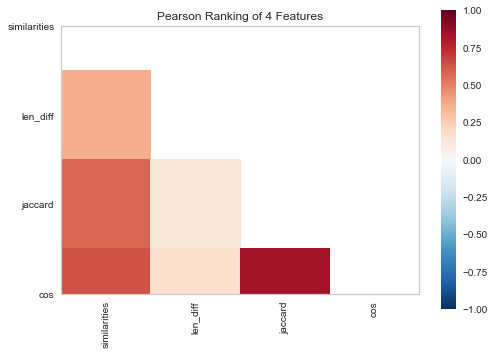

In [70]:
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import Rank2D
from yellowbrick.datasets import load_credit

# Load the credit dataset
X, y = load_credit()

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson')

X = all_train_and_testset['pd']['x_trainset']
print(X)
X = X[['similarities','len_diff','jaccard','cos']]

visualizer.fit(X, all_train_and_testset['pd']['y_trainset'])  
visualizer.transform(X) 
visualizer.show()
# Fit the data to the visualizer
#visualizer.transform(X)        # Transform the data
#visualizer.show()              # Finalize and render the figure         # Finalize and render the figure

#visualizer = Rank2D(algorithm="pearson")
#visualizer.fit_transform(all_train_and_testset['pd']['x_trainset'])
#visualizer.show()

C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


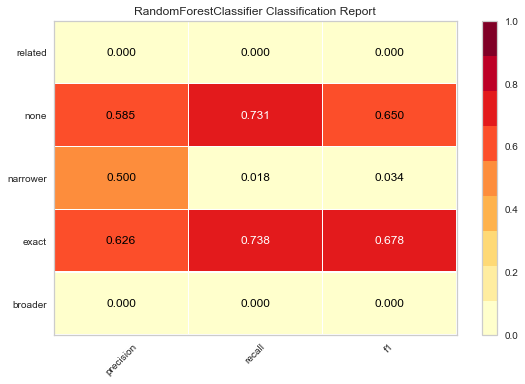

In [42]:


model = RandomForestClassifier(max_depth=10, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=50)
visualizer = ClassificationReport(model)
visualizer.fit(all_train_and_testset['pd']['x_trainset'], all_train_and_testset['pd']['y_trainset'])
visualizer.score(all_train_and_testset['pd']['x_testset'], all_train_and_testset['pd']['y_testset'])
visualizer.show()

In [93]:
all_data = load_training_data(folder)
en_data = all_data['english_kd']
print(set(en_data['relation']))


{'narrower', 'none', 'related', 'broader', 'exact'}


NameError: name 'sent_tokenize' is not defined

In [114]:
from nltk.tokenize import word_tokenize, sent_tokenize
import pattern.en
nltk.download('punkt')
nltk.download('stopwords')
from pattern.en import tag
from nltk.corpus import wordnet as wn

from nltk.stem import WordNetLemmatizer
stopword_list = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer()

def pos_tag_text(text):
    
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None
    
    tagged_text = tag(text)
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in
                         tagged_text]
    return tagged_lower_text
def lemmatize_text(text):
    
    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                         else word                     
                         for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

def remove_stopwords(text):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


lemmatized = lemmatize_text(en_data['def1'][0])
lemmatized

lemma_stopwords = remove_stopwords(lemmatized)

tokens = tokenize_text(lemma_stopwords)
tokens


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\syim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\syim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['away', 'longer', 'touch']

**Add Text Classifier to the pipeline**

**Print only narrower relations**

In [5]:
#df['def1']=df['def1'].str.wrap(20)
is_narrower = en_data['relation']=='narrower'
def is_not_none(df):
    return df['relation']!='none'
def is_none(df):
    return df['relation']=='none'

print(en_data[is_not_none])

          word          pos  \
0    off        preposition   
3    off        preposition   
8    off        preposition   
13   off        preposition   
15   off        adverb        
..   ...           ...        
530  on         preposition   
551  on         preposition   
552  one        number        
553  one        number        
554  offspring  noun          

                                                    def1  \
0    away from and no longer touching                      
3    in a position away from                               
8    not inside a large vehicle used by the public         
13   not eating or taking                                  
15   away from a place                                     
..                 ...                                     
530  indicates sth or sb uses a type of food, fuel, etc.   
551  immediately following                                 
552  the number 1                                          
553  the number 1          

**Run Spacy NLP Pipeline**

In [16]:
def spacyDocForVec(sentence):
    return nlp(sentence)

modDfObj = pd.DataFrame()
en_data['processed_1'] = en_data['def1'].map(spacyDocForVec)
en_data['processed_2'] = en_data['def2'].map(spacyDocForVec)
#doc_list = spacyDocForVec(en_data['def1'])
#doc_list2 = spacyDocForVec(en_data['def2'])

In [90]:
from nltk import collections

en_data['processed_1'][0].vocab
deps = collections.defaultdict(set)

for row in en_data['processed_1']:
    print(row.__len__())
    #for token in en_:
     #   deps.add(token.dep_)
        #print(deps)
        
#deps
    #print(token.text, "| lemma:", token.lemma_, "| norm:" , token.norm_, "| pos:" ,token.pos_, "| tag:", token.tag_, "| dep:", token.dep_, "| sentiment:", token.sentiment)

6
6
6
5
5
5
9
9
9
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
9
9
9
9
9
9
9
9
5
5
5
5
5
5
5
5
4
4
4
4
4
4
4
4
8
8
8
8
8
8
8
8
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
16
16
4
4
6
6
6
12
12
12
3
3
3
7
7
8
8
12
12
7
7
9
9
9
9
5
5
8
8
8
8
5
5
8
9
7
7
3
3
10
10
17
17
9
9
11
11
8
12
7
7
9
9
4
3
9
11
13
9
5
3
3
3
3
3
3
3
3
3
5
5
5
5
5
10
10
10
10
10
8
8
8
8
8
1
1
1
1
1
2
2
2
2
2
6
6
6
6
6
2
2
6
6
4
4
1
1
1
1
6
6
5
5
5
5
3
10
10
4
4
19
19
19
19
12
12
13
13
3
3
3
3
8
8
8
8
13
13
13
13
4
4
4
4
11
9
9
10
5
6
6
2
2
2
2
2
2
2
17
17
17
17
17
17
17
3
3
3
3
3
3
3
13
13
13
13
13
13
13
5
5
5
5
5
5
5
10
10
10
10
10
10
10
4
4
4
4
4
4
4
8
8
8
8
8
8
8
8
8
8
8
8
8
8
13
13
13
13
13
13
13
10
10
17
17
15
15
11
11
5
5
5
5
5
5
9
9
9
9
5
5
5
5
11
11
2
2
2
2
2
2
2
2
2
2
7
7
7
7
7
5
5
5
5
5
14
14
14
14
4
4
4
4
8
8
5
5
5
5
5
5
5
5
5
5
5
5
5
5
8
8
8
8
8
8
8
8
8
8
8
8
8
8
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
8
8
8
8
8
8
8
8
8
8
8
8
8
8
5
5
5
5
5
5
5
5
5
5
5
5
5
5
10
10
10
10
1

In [8]:
#df['def1_nlp']=doc_list
#df['def2_nlp']=doc_list2

55

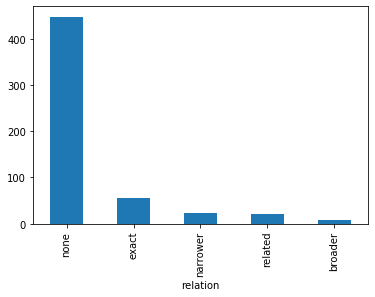

In [11]:
#modDfObj['def1'][0].sents
label_count = en_data.groupby('relation').count().word.sort_values(ascending=False)

label_count.plot(kind = 'bar')
label_count[1]
#label_count.plot(kind = 'bar', x = 'relation', y )

In [21]:
#t1 = doc_list2[0]
#for token in doc_list2[0]
#    print(token.text, "| lemma:", token.lemma_, "| norm:" , token.norm_, "| pos:" ,token.pos_, "| tag:", token.tag_, "| dep:", token.dep_, "| sentiment:", token.sentiment)
en_data

,word,pos,def1,def2,relation,processed_1,processed_2
0,off,preposition,away from and no longer touching,away from; down from,narrower,"(away, from, and, no, longer, touching)","(away, from, ;, down, from)"
1,off,preposition,away from and no longer touching,not wanting or allowed to have (food etc),none,"(away, from, and, no, longer, touching)","(not, wanting, or, allowed, to, have, (, food, etc, ))"
2,off,preposition,away from and no longer touching,"out of (a vehicle, train etc)",none,"(away, from, and, no, longer, touching)","(out, of, (, a, vehicle, ,, train, etc, ))"
3,off,preposition,in a position away from,away from; down from,narrower,"(in, a, position, away, from)","(away, from, ;, down, from)"
4,off,preposition,in a position away from,not wanting or allowed to have (food etc),none,"(in, a, position, away, from)","(not, wanting, or, allowed, to, have, (, food, etc, ))"
...,...,...,...,...,...,...,...
551,on,preposition,immediately following,followed by,related,"(immediately, following)","(followed, by)"
552,one,number,the number 1,the number or figure 1,exact,"(the, number, 1)","(the, number, or, figure, 1)"
553,one,number,the number 1,the age of 1,related,"(the, number, 1)","(the, age, of, 1)"
554,offspring,noun,a person's child or an animal's baby,"(formal, humorous) someone's child or children",broader,"(a, person, 's, child, or, an, animal, 's, baby)","((, formal, ,, humorous, ), someone, 's, child, or, children)"


     similarities  first_word_same  len_diff   jaccard
0    0.856918      True             2         0.250000
1    0.776428      False            3         0.000000
2    0.732969      False            3         0.000000
3    0.836521      False            1         0.285714
4    0.689816      False            2         0.000000
..        ...        ...           ..              ...
551  0.615553      False            6         0.000000
552  0.915048      True             0         0.600000
553  0.822070      True             0         0.400000
554  0.850948      False            1         0.181818
555  0.934649      False            5         0.500000

[556 rows x 4 columns]


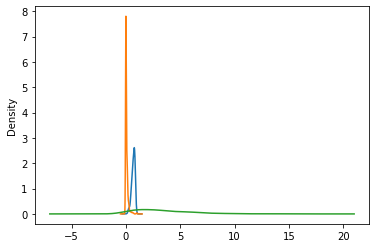

In [40]:
def sentence2vec(row):
    return row['processed_1'].similarity(row['processed_2'])

    
def first_word_same(row):
    return row['def1'].split(' ')[0].lower() == row['def2'].split(' ')[0].lower()

def difference_in_length(row):
    return abs(len(row['def1'].split(' ')) - len(row['def2'].split(' ')[0]))

def jaccard_sim(row):
    return get_jaccard_sim(row['def1'], row['def2'])


def cosine(row):
    return get_cosine_sim(row['def1'], row['def2'])[0, 1]

def get_jaccard_sim(str1, str2):
    a = set(str1.split())
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


features = pd.DataFrame()

similarities = []
first_word = []
length = []

features['similarities'] = en_data.apply(lambda row: sentence2vec(row), axis = 1)
features['first_word_same'] = en_data.apply(lambda row: first_word_same(row), axis=1)
features['len_diff'] = en_data.apply(lambda row: difference_in_length(row), axis=1)
features['jaccard'] = en_data.apply(lambda row: jaccard_sim(row), axis=1)
print(features)
#features['len_diff'].plot(kind = 'hist')
features['similarities'].plot.kde()
features['jaccard'].plot.kde()
features['len_diff'].plot.kde()
#for i, row in en_data.iterrows():
#    similarities.append(sentence2Vec(row))
#    first_word.append(first_word_same(row))
#    length.append(difference_in_length(row)) 

#features['similarities'] = similarities
#features['first_word_same'] = first_word
#features['length'] = length
#Add Token Count using CountVectorizer

55

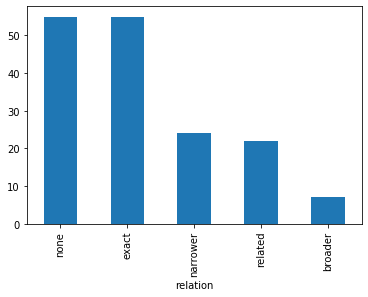

In [374]:
#none = features[is_none(features)==True]

#label_count = en_data.groupby('relation').count().word.sort_values(ascending=False)
#second_biggest = label_count[1]
#to_drop = none.index[second_biggest:]

#balanced = features.drop(to_drop) 
#balanced
#label_count = balanced.groupby('relation').count().similarities.sort_values(ascending=False)

#label_count.plot(kind = 'bar')
#label_count[1]
#second_biggest
#label_count.plot(kind = 'bar')



In [54]:
#en_data['similarities'] = similarities
labels = en_data['relation']
features = features.drop(['relation'], axis=1)
features

,similarities,first_word_same,len_diff,jaccard
0,0.856918,True,2,0.250000
1,0.776428,False,3,0.000000
2,0.732969,False,3,0.000000
3,0.836521,False,1,0.285714
4,0.689816,False,2,0.000000
...,...,...,...,...
551,0.615553,False,6,0.000000
552,0.915048,True,0,0.600000
553,0.822070,True,0,0.400000
554,0.850948,False,1,0.181818


**Split Dataset**

,similarities,first_word_same,len_diff,jaccard
69,0.689137,False,1,0.000000
253,0.765570,False,9,0.058824
139,0.800568,False,4,0.000000
286,0.756537,False,2,0.000000
221,0.863854,False,9,0.000000
...,...,...,...,...
346,0.710593,False,4,0.000000
443,0.566016,False,0,0.000000
295,0.736717,False,2,0.100000
554,0.850948,False,1,0.181818


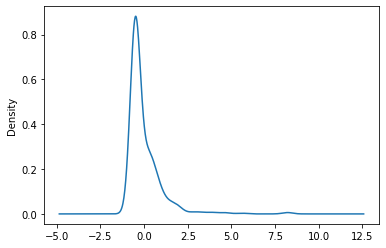

In [65]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2)
X_train_scaled = X_train.copy(deep = True)
X_test_scaled = X_test.copy(deep = True)

X_train_scaled['similarities'] = preprocessing.scale(X_train['similarities'])
X_train_scaled['len_diff'] = preprocessing.scale(X_train['len_diff'])
X_train_scaled['jaccard'] = preprocessing.scale(X_train['jaccard'])
#X_train_scaled['length'] = preprocessing.scale(X_train['length'])
#X_test_scaled['similarities'] = preprocessing.scale(X_test['similarities'])
#X_test_scaled['length'] = preprocessing.scale(X_test['length'])
#features['similarities'].plot.kde()
#X_train_scaled['similarities'].plot.kde()
X_train_scaled['jaccard'].plot.kde()
#X_train_scaled['len_diff'].plot.kde()

X_train_set = {}
X_train_set['unscaled'] = X_train
X_train_set['scaled'] = X_train_scaled

X_test_set = {}
X_test_set['unscaled'] = X_test
X_test_set['scaled'] = X_test_scaled

X_test_set['unscaled']


In [64]:
def get_baseline(test_set):
    TP = 0
    for index in test_set.index:
        if test_set[index]=='none':
            TP+=1

    return float(TP/len(test_set))


def run_cv_with_dataset(model, trainset, y_train):
    scores = cross_val_score(model, trainset, y_train, cv = 5)        
    print('Cross validation scores for model' + model.__class__.__name__)
    #scores
    print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

def cross_val_models(models, all_training_set, y_train):
    for estimator in models['unscaled']:
        run_cv_with_dataset(estimator, all_training_set['unscaled'], y_train)
    
    for estimator in models['scaled']:
        run_cv_with_dataset(estimator, all_training_set['scaled'], y_train)

def compare_on_testset(models, testset_x, testset_y, testset_x_scaled):
    print('Model Evaluation on Testset: ' + '\n')
    print('\t' + 'BASELINE: ' + str(get_baseline(testset_y)) + '\n')
    
    for estimator in models['unscaled']:
        estimator.predict(testset_x)
        print('\t' + estimator.__class__.__name__)
        score = estimator.score(testset_x, testset_y)
        print('\t\t' + "Accuracy: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2) + '\n')
    
    for estimator in models['scaled']:
        estimator.predict(testset_x_scaled)
        print('\t' + estimator.__class__.__name__)
        score = estimator.score(testset_x_scaled, testset_y)
        print('\t\t' + "Accuracy for scaled featureset: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2) + '\n')

def train_models(X_train, y_train, X_train_scaled):
    print('baseline: ', str(get_baseline(y_test)) + '\n')

    LR = LogisticRegression( solver = 'lbfgs', multi_class = 'multinomial').fit(X_train, y_train)
    LR_scaled = LogisticRegression( solver = 'lbfgs', multi_class = 'multinomial').fit(X_train_scaled, y_train)

    ## Linear kernal won't work very well, experiment with nonlinear ones.
    SVM = svm.LinearSVC(C=10.0).fit(X_train, y_train)
    SVM_scaled = svm.LinearSVC().fit(X_train_scaled, y_train)

    RF = RandomForestClassifier(max_depth = 5, random_state=0).fit(X_train, y_train)
    RF_scaled = RandomForestClassifier(max_depth = 5, random_state=0).fit(X_train_scaled, y_train)
    
    models = {}
    models['unscaled'] = [LR, SVM, RF]
    models['scaled'] = [LR_scaled, SVM_scaled, RF_scaled]
    
    return models

models = train_models(X_train, y_train, X_train_scaled)
cross_val_models(models, X_train_set, y_train)
#print(models)
compare_on_testset(models, X_test, y_test, X_test_scaled)


baseline:  0.7857142857142857



C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\s

Cross validation scores for modelLogisticRegression
Accuracy: 0.8224 (+/- 0.0373)


C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: C

Cross validation scores for modelLinearSVC
Accuracy: 0.8157 (+/- 0.0440)
Cross validation scores for modelRandomForestClassifier
Accuracy: 0.8133 (+/- 0.0611)
Cross validation scores for modelLogisticRegression
Accuracy: 0.8156 (+/- 0.0381)


C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: C

Cross validation scores for modelLinearSVC
Accuracy: 0.8179 (+/- 0.0419)
Cross validation scores for modelRandomForestClassifier
Accuracy: 0.8133 (+/- 0.0611)
Model Evaluation on Testset: 

	BASELINE: 0.7857142857142857

	LogisticRegression
		Accuracy: 0.7857 (+/- 0.0000)

	LinearSVC
		Accuracy: 0.7768 (+/- 0.0000)

	RandomForestClassifier
		Accuracy: 0.7857 (+/- 0.0000)

	LogisticRegression
		Accuracy for scaled featureset: 0.7857 (+/- 0.0000)

	LinearSVC
		Accuracy for scaled featureset: 0.7857 (+/- 0.0000)

	RandomForestClassifier
		Accuracy for scaled featureset: 0.7857 (+/- 0.0000)



In [23]:
if "textcat" not in nlp.pipe_names:
    textcat = nlp.create_pipe(
        "textcat", config={"exclusive_classes": True, "architecture": "simple_cnn"}
    )
    nlp.add_pipe(textcat, last=True)
    # otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe("textcat")
    
textcat.add_label('related')
textcat.add_label('exact')
textcat.add_label('broader')
textcat.add_label('narrower')
textcat.add_label('none')




# TODO
## Experiment with NLP Pipeline

In [16]:
def lemmatizer(doc):
        # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)

def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.
#nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
#nlp.add_pipe(remove_stopwords, name="stopwords", last=True)